# Descarga del conjunto de datos y preprocesamiento

Lo primero que necesitamos hacer es descargarnos el conjunto de datos. Al igual que en el ejemplo original, lo que vamos a hacer es utilizar el Open Images Dataset v4 de Google (https://storage.googleapis.com/openimages/web/download.html).
Para esto necesitamos guardar lo siguiente en nuestro directorio de trabajo (observar la figura):
- Metadatos de Class Names, que nos descragara el archivo $class-descriptions-boxable.csv$.
- Las imagenes seran del sitio Figure Eight. Se te abrira una nueva pagina de la cual te puedes descargar los archivos $train-annotaion-bbox.csv$ y $train-images-boxable.csv$ como se ve en la segunda figura.

![title](jupyter_images/google.png)

![title](jupyter_images/figure8.png)



# Entendiendo la informacion

Una vez que hemos descargado estos archivos, que como se puede ver NO contienen imagenes, vamos a tratar de entender que informacion contienen. Pero primero vamos a importar las librerias que necesitamos para nuestro proyecto.

In [1]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile
import cv2
import tensorflow as tf

Ahora vamos a definir las variables para poder manejar nuestros archivos descargados.

In [3]:
ruta_archivos = '/home/julio/ObjectDetection' #El directorio en el que descargamos los archivos
archivo_imagenes = 'train-images-boxable.csv'
archivo_etiquetas = 'train-annotations-bbox.csv'
archivo_clases = 'class-descriptions-boxable.csv'

Finalmente vemos que es lo que contienen estos archivos.

In [8]:
imagenes = pd.read_csv(os.path.join(ruta_archivos, archivo_imagenes))
print('\nArchivo imagenes:\n',imagenes.head())
etiquetas = pd.read_csv(os.path.join(ruta_archivos, archivo_etiquetas))
print('\nArchivo etiquetas:\n',etiquetas.head())
#Colocar los nombres de las columnas manualmente (name, class). No fue asi en el ejemplo original, pero en mi caso es necesario.
clases = pd.read_csv(os.path.join(ruta_archivos, archivo_clases), names = ['name','class'])
print('\nArchivo clases:\n',clases.head())

Archivo imagenes:
              image_name                                          image_url
0  e39871fd9fd74f55.jpg  https://requestor-proxy.figure-eight.com/figur...
1  f18b91585c4d3f3e.jpg  https://requestor-proxy.figure-eight.com/figur...
2  ede6e66b2fb59aab.jpg  https://requestor-proxy.figure-eight.com/figur...
3  ed600d57fcee4f94.jpg  https://requestor-proxy.figure-eight.com/figur...
4  ff47e649b23f446d.jpg  https://requestor-proxy.figure-eight.com/figur...
Archivo etiquetas:
             ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepic

Como podemos ver, el primer archivo contiene los enlaces para poder descargarnos cada una de las imagenes. El segundo contiene las coordenadas de los recuadros que limitan un objeto dentro de la imagen (bounding box). Finalmente el tercer archivo contiene las clases (objetos) a los que corresponden los recuadros del archivo anterior.

Para poder entender de manera mas clara esta informacion, y la manera en que podemos usarla en nuestro proyecto, vamos a tomar una imagen y la vamos a mostrar conjuntamente con los recuadros descritos anteriormente. Es la imagen 42, pero podria ser cualquiera. Ahora, si no sabes por que la 42, tienes que leer "La Guía del autoestopista galáctico" (The Hitchhiker's Guide to the Galaxy).

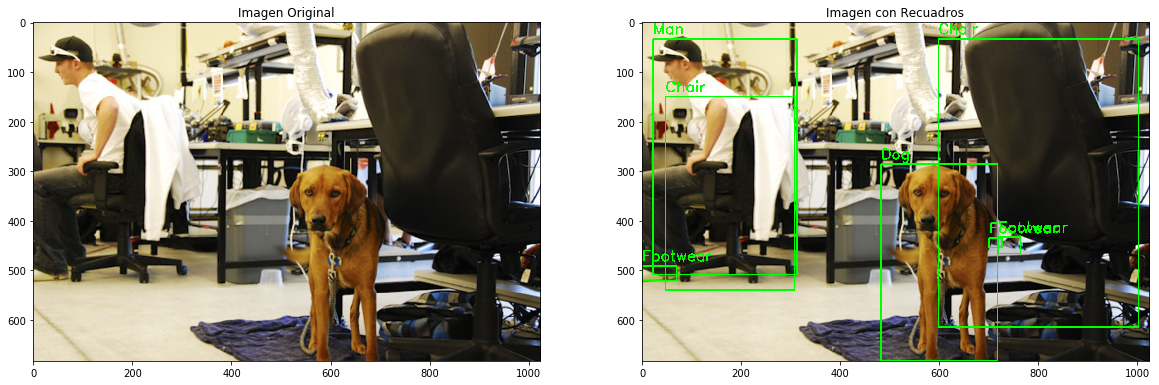

In [12]:
#Seleccionamos la imagen
ejemplo_imagen = imagenes['image_name'][42]
ejemplo_url = imagenes['image_url'][42]
img = io.imread(ejemplo_url)

#Mostramos nuestro ejemplo
alto, ancho, profundidad = img.shape #Las dimensiones de la imagen
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Imagen Original')
plt.imshow(img)
img_id = ejemplo_imagen[:16] #Toma el nombre del archivo sin la extension
recuadro = etiquetas[etiquetas['ImageID']==img_id] #Obtenemos la informacion de los recuadros para nuestra imagen ejemplo
img_recuadro = img.copy()
for indice, fila in recuadro.iterrows():
    xmin = fila['XMin']
    xmax = fila['XMax']
    ymin = fila['YMin']
    ymax = fila['YMax']
    xmin = int(xmin*ancho)
    xmax = int(xmax*ancho)
    ymin = int(ymin*alto)
    ymax = int(ymax*alto)
    nombre_etiqueta = fila['LabelName']# En estas tres lineas, obtenemos los nombres reales de las etiquetas en la imagen
    etiqueta_real = clases[clases['name']==nombre_etiqueta]
    nombre_etiqueta_real = etiqueta_real['class'].values[0]
    cv2.rectangle(img_recuadro,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_recuadro,nombre_etiqueta_real,(xmin,ymin-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Imagen con Recuadros')
plt.imshow(img_recuadro)
plt.show()

Hasta ahora, lo que hemos logrado es mostrar una imagen con sus recuadros etiquetados, directamente desde el conjunto de datos disponible en linea.
Ahora necesitamos obtener un subconjunto de ese conjunto de imagenes y adecuarlas para poder entrenar nuestra red.